<a href="https://colab.research.google.com/github/putricinto/Machine-Learning-Project---MLCC/blob/master/Exercise1_Bank_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**



**Read in the csv data with pandas**





In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [53]:
url = 'https://raw.githubusercontent.com/putricinto/Machine-Learning-Project---MLCC/master/bank.csv'
bank = pd.read_csv(url)
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


**Informations and Charactheristics of The Data**

In [54]:
bank.info()
bank.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


## **Data Visualization**

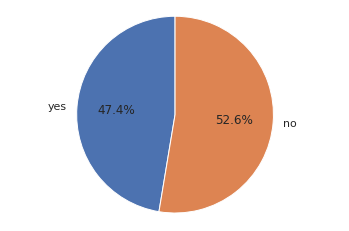

In [55]:
#Pie Chart of The Label (Deposit)
y=list(bank['deposit'])
labels = 'yes', 'no'
sizes = [y.count('yes'), y.count('no')]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

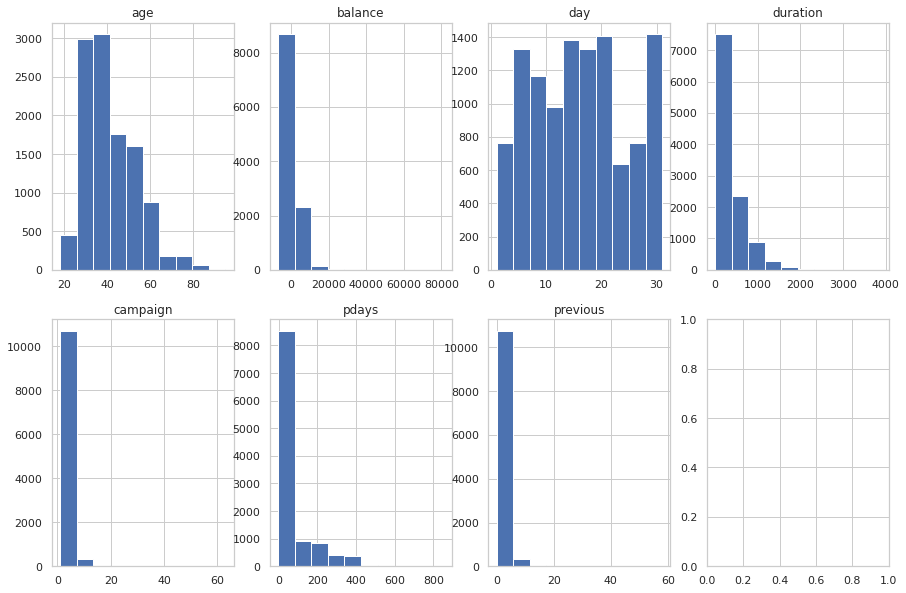

In [56]:
#Histigram of Numerical Variables
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

colors = ['pink']
axs[0, 0].hist(bank['age'])
axs[0, 0].set_title('age')

axs[0, 1].hist(bank['balance'])
axs[0, 1].set_title('balance')

axs[0, 2].hist(bank['day'])
axs[0, 2].set_title('day')

axs[0, 3].hist(bank['duration'])
axs[0, 3].set_title('duration')

axs[1, 0].hist(bank['campaign'])
axs[1, 0].set_title('campaign')

axs[1, 1].hist(bank['pdays'])
axs[1, 1].set_title('pdays')

axs[1, 2].hist(bank['previous'])
axs[1, 2].set_title('previous')

plt.show()

In [0]:
#Because so many outliers on balance, pdyas, previous, campaign, and duration
#we decide to change into categorical variables
def pdays(row):
    if row['pdays'] == -1:
        val = 0
    else:
        val = 1
    return val
def previous(row):
    if row['previous'] == 0:
        val = 0
    else:
        val = 1
    return val
def campaign(row):
    if row['campaign'] == 0:
        val = 0
    else:
        val = 1
    return val
def balance(row):
    if row['balance'] == 0:
        val = 0
    elif row['balance']<0:
        val = -1
    else:
        val = 1
    return val
def duration_bin1(row):
    if row['duration']<=1000:
        val = 1
    else:
        val = 0
    return val
def duration_bin2(row):
    if 1000<row['duration']<=2000:
        val = 1
    else:
        val = 0
    return val
def duration_bin3(row):
    if 2000<row['duration']<=3000:
        val = 1
    else:
        val = 0
    return val
bank['pdays_1'] = bank.apply(pdays, axis=1)
bank['previous_1'] = bank.apply(previous, axis=1)
bank['campaign_1'] = bank.apply(campaign, axis=1)
bank['balance_1'] = bank.apply(balance, axis=1)
bank['duration_bin1']=bank.apply(duration_bin1, axis=1)
bank['duration_bin2']=bank.apply(duration_bin2, axis=1)
bank['duration_bin3']=bank.apply(duration_bin3, axis=1)

In [0]:
bank=bank.drop(['pdays','previous','campaign','balance','duration'],1)

## **Overcoming The Outliers**

In [59]:
bank1=bank.drop(['job','marital','education','default','housing','loan','contact','month','poutcome','pdays_1','previous_1','campaign_1','balance_1','duration_bin1','duration_bin2','duration_bin3','deposit'],1)
#Mengatasi Outlier
import numpy as np
from scipy import stats
z=np.abs(stats.zscore(bank1._get_numeric_data()))
print(z)
bank=bank[(z<3).all(axis=1)]
print(bank.shape)

[[1.49150488 1.26574556]
 [1.23967567 1.26574556]
 [0.0194704  1.26574556]
 ...
 [0.77495804 0.39689074]
 [0.14841574 0.90946635]
 [0.6070719  0.79070662]]
(11030, 19)


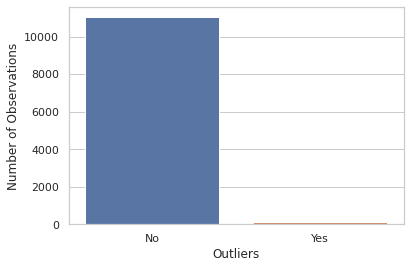

In [62]:
#Numbers of Outlier
sns.set(style="whitegrid")
c=pd.DataFrame([])
c['Outliers']=["No","Yes"]
c['Number of Observations']=[11030,132]
bx = sns.barplot(x="Outliers", y="Number of Observations",data=c)
plt.show()

Text(0.5, 1.0, 'day')

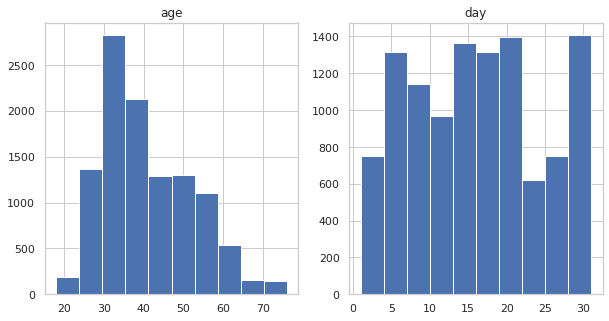

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

colors = ['pink']
axs[0].hist(bank['age'])
axs[0].set_title('age')

axs[1].hist(bank['day'])
axs[1].set_title('day')

In [64]:
bank['deposit'] = bank['deposit'].replace('yes', 1)
bank['deposit'] = bank['deposit'].replace('no', 0)
bank['deposit']

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11030, dtype: int64

In [65]:
bank.describe()

,age,day,deposit,pdays_1,previous_1,campaign_1,balance_1,duration_bin1,duration_bin2,duration_bin3
count,11030.000000,11030.000000,11030.000000,11030.000000,11030.000000,11030.0,11030.000000,11030.000000,11030.000000,11030.000000
mean,40.756936,15.664823,0.470354,0.252312,0.252312,1.0,0.805893,0.936899,0.060199,0.002267
std,11.151027,8.424056,0.499143,0.434359,0.434359,0.0,0.530288,0.243155,0.237867,0.047556
min,18.000000,1.000000,0.000000,0.000000,0.000000,1.0,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,8.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
50%,38.000000,15.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
75%,49.000000,22.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000
max,76.000000,31.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [67]:
bank["deposit_is_yes"] = (bank["deposit"] > 0).astype(float)
bank["deposit_is_yes"]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
11157    0.0
11158    0.0
11159    0.0
11160    0.0
11161    0.0
Name: deposit_is_yes, Length: 11030, dtype: float64

## **Data Standarization**

In [86]:
age_mean = bank['age'].mean()
age_std = bank['age'].std()
age_norm = (bank['age']-age_mean)/age_std
age_norm

0        1.635999
1        1.366965
2        0.021797
3        1.277287
4        1.187609
           ...   
11157   -0.695625
11158   -0.157558
11159   -0.785303
11160    0.201153
11161   -0.605947
Name: age, Length: 11030, dtype: float64

In [87]:
day_mean = bank['day'].mean()
day_std = bank['day'].std()
day_norm = (bank['day']-day_mean)/day_std
day_norm

0       -1.265996
1       -1.265996
2       -1.265996
3       -1.265996
4       -1.265996
           ...   
11157    0.514619
11158    0.039788
11159    0.395911
11160   -0.909873
11161   -0.791166
Name: day, Length: 11030, dtype: float64

## **Create the Feature Columns for tf.esitmator**

In [0]:
feature_columns = []

In [0]:
age = feature_column.numeric_column("age")
day = feature_column.numeric_column("day")
pdays_1=feature_column.numeric_column("pdays_1")
campaign_1=feature_column.numeric_column("campaign_1")
previous_1=feature_column.numeric_column("previous_1")
duration_bin1=feature_column.numeric_column("duration_bin1")
duration_bin2=feature_column.numeric_column("duration_bin2")
duration_bin3=feature_column.numeric_column("duration_bin3")

In [90]:
def get_normalization_parameters(bank, features):
  def _z_score_params(column):
    mean = bank[column].mean()
    std = bank[column].std()
    return {'mean': mean, 'std': std}
  
  normalization_parameters = {}
  for column in features:
    normalization_parameters[column] = _z_score_params(column)
  return normalization_parameters

NUMERIC_FEATURES = ['age','day', 'pdays_1','campaign_1','previous_1',
                    'duration_bin1', 'duration_bin2', 'duration_bin3']
normalization_parameters = get_normalization_parameters(bank,
                                                        NUMERIC_FEATURES)
normalization_parameters

{'age': {'mean': 40.756935630099726, 'std': 11.151026565111755},
 'campaign_1': {'mean': 1.0, 'std': 0.0},
 'day': {'mean': 15.66482320942883, 'std': 8.424055785475465},
 'duration_bin1': {'mean': 0.9368993653671804, 'std': 0.24315489890095324},
 'duration_bin2': {'mean': 0.060199456029011784, 'std': 0.23786679302643937},
 'duration_bin3': {'mean': 0.0022665457842248413, 'std': 0.047556425396187645},
 'pdays_1': {'mean': 0.25231187669990934, 'std': 0.4343589512547633},
 'previous_1': {'mean': 0.25231187669990934, 'std': 0.4343589512547633}}

In [0]:
def _numeric_column_normalized(column_name, normalizer_fn):
    return tf.feature_column.numeric_column(column_name, normalizer_fn=normalizer_fn)

def make_zscaler(mean, std):
    def zscaler(col):
        return (col - mean)/std
    return zscaler

# Define your feature columns
def create_feature_cols(features, use_normalization):
    """Create feature columns using tf.feature_column. 
    
    This function will get executed during training, evaluation, and serving."""
    def normalize_column(col):  # Use mean, std defined below.
        return (col - mean)/std
    normalized_feature_columns = []
    for column_name in features:
        normalizer_fn = None
        if use_normalization:
            column_params = normalization_parameters[column_name]
            mean = column_params['mean']
            std = column_params['std']
            normalizer_fn = make_zscaler(mean, std)
        normalized_feature_columns.append(_numeric_column_normalized(column_name,
                                                                     normalizer_fn))
    return normalized_feature_columns

NUMERIC_FEATURES = ['age','day', 'pdays_1','campaign_1','previous_1',
                    'duration_bin1', 'duration_bin2', 'duration_bin3']
feature_columns = create_feature_cols(NUMERIC_FEATURES, use_normalization=True)

In [92]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c268>),
 NumericColumn(key='day', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c1e0>),
 NumericColumn(key='pdays_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c2f0>),
 NumericColumn(key='campaign_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c378>),
 NumericColumn(key='previous_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c6a8>),
 NumericColumn(key='duration_bin1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c730>),
 NumericColumn(key='duration_bin2', shape=(1,), default_value=None

In [0]:
job = feature_column.categorical_column_with_vocabulary_list(
      'job',['admin.','blue-collar','entrepreneur','housemaid','management',
             'retired','self-employed','services','student','technician',
             'unemployed','unknown'])
marital = feature_column.categorical_column_with_vocabulary_list(
      'marital',['divorced','married','single'])
education = feature_column.categorical_column_with_vocabulary_list(
      'education',['primary','secondary','tertiary','unknown'])
default = feature_column.categorical_column_with_vocabulary_list(
      'default',['no','yes'])
housing = feature_column.categorical_column_with_vocabulary_list(
      'housing',['no','yes'])
loan = feature_column.categorical_column_with_vocabulary_list(
      'loan',['no','yes'])
contact = feature_column.categorical_column_with_vocabulary_list(
      'contact',['cellular','telephone','unknown'])
month = feature_column.categorical_column_with_vocabulary_list(
      'month',['jan','feb','mar','apr','may','jun','jul','aug','sep','oct',
               'nov','dec'])
poutcome = feature_column.categorical_column_with_vocabulary_list(
      'poutcome',['failure','success','unknown','other'])
balance_1 = feature_column.categorical_column_with_vocabulary_list(
      'balance_1',[-1,0,1])

In [0]:
job_hot = feature_column.indicator_column(job)
marital_hot = feature_column.indicator_column(marital)
education_hot = feature_column.indicator_column(education)
default_hot = feature_column.indicator_column(default)
housing_hot = feature_column.indicator_column(housing)
loan_hot = feature_column.indicator_column(loan)
contact_hot = feature_column.indicator_column(contact)
month_hot = feature_column.indicator_column(month)
poutcome_hot = feature_column.indicator_column(poutcome)
balance_1_hot = feature_column.indicator_column(balance_1)

In [0]:
feature_columns.append(job_hot)
feature_columns.append(marital_hot)
feature_columns.append(education_hot)
feature_columns.append(default_hot)
feature_columns.append(housing_hot)
feature_columns.append(loan_hot)
feature_columns.append(contact_hot)
feature_columns.append(month_hot)
feature_columns.append(poutcome_hot)
feature_columns.append(balance_1_hot)

In [96]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c268>),
 NumericColumn(key='day', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c1e0>),
 NumericColumn(key='pdays_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c2f0>),
 NumericColumn(key='campaign_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c378>),
 NumericColumn(key='previous_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c6a8>),
 NumericColumn(key='duration_bin1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function make_zscaler.<locals>.zscaler at 0x7f7f1a98c730>),
 NumericColumn(key='duration_bin2', shape=(1,), default_value=None

In [0]:
feature_layer = layers.DenseFeatures(feature_columns)

In [98]:
feature_layer

## **Hyperparameter Tuning**

In [99]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        

def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [100]:
def plot_curve(epochs, hist, list_of_metrics): 
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [0]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "deposit_is_yes"
classification_threshold = 0.35

METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]


In [0]:
my_model = create_model(learning_rate, feature_layer, METRICS)


In [85]:
epochs, hist = train_model(my_model,bank,epochs,label_name,batch_size)

Epoch 1/20


TypeError: ignored

In [0]:
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

**Perform a Train Test Split on the Data**

In [0]:
x_data = bank.drop('deposit',axis=1)
y_labels = bank['deposit']
X_train, X_test, y_train, y_test = train_test_split(
      x_data,y_labels,test_size=0.3,random_state=101)

**Put all these variables into a single list with the variable name feat_cols**

In [0]:
feat_cols = [job_hot,marital_hot,education_hot,default_hot,housing_hot,
             loan_hot,contact_hot,month_hot,poutcome_hot,balance_1_hot,age,day,pdays_1,campaign_1,previous_1,duration_bin1,duration_bin2,duration_bin3]

**Create Input Function**

In [0]:
input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,
                                                 y=y_train,
                                                 batch_size=10,
                                                 num_epochs=None,
                                                 shuffle=True)

**Create your model with tf.estimator**

In [0]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuyyxeqsc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
model

**Train your model on the data, for at least 5000 steps**

In [0]:
model.train(input_fn=input_func,steps=5000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Please use `layer.add_weight` method instead.
Ins

**Create a prediction input function**

In [0]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=X_test,batch_size=len(X_test),shuffle=False)

**Use model.predict() and pass in your input function**

In [0]:
predictions = list(model.predict(input_fn=pred_fn))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuyyxeqsc/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


**Each item in your list will look like this:**

In [0]:
predictions[0]

{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.19804242], dtype=float32),
 'logits': array([-1.3985746], dtype=float32),
 'probabilities': array([0.8019576 , 0.19804241], dtype=float32)}

**Create a list of only the class_ids key values from the prediction list of dictionaries, these are the predictions you will use to compare against the real y_test values**

In [0]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

In [0]:
final_preds[:20]

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]

In [0]:
eval_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=X_test,y=y_test,batch_size=len(X_test),shuffle=False)

In [0]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1734
           1       0.67      0.74      0.70      1575

    accuracy                           0.70      3309
   macro avg       0.71      0.71      0.70      3309
weighted avg       0.71      0.70      0.70      3309



In [0]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-28T05:09:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpuyyxeqsc/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.06148s
INFO:tensorflow:Finished evaluation at 2020-03-28-05:09:20
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.703838, accuracy

{'accuracy': 0.703838,
 'accuracy_baseline': 0.5240254,
 'auc': 0.79451126,
 'auc_precision_recall': 0.7937835,
 'average_loss': 0.55296165,
 'global_step': 5000,
 'label/mean': 0.47597462,
 'loss': 0.55296165,
 'precision': 0.672664,
 'prediction/mean': 0.5475833,
 'recall': 0.73587304}

# Linear Classification

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
url = 'https://raw.githubusercontent.com/juliussin/Machine-Learning-Project---MLCC/master/bank.csv'
bank = pd.read_csv(url)
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [0]:
data = bank.copy()
data = data.drop('day', axis=1)
data = data.drop('month', axis=1)
#Normalize Age & Day
data['age'] = data['age']/100
data['balance'] = (data['balance']+10000)/100000
# data['day'] = data['day']/32
# data['previous'] = data['previous']/64
# data['duration'] = data['duration']/1000
dict_of_feature_column = {}

for i in data.columns:

  # for Categorical Features
  if data[i].unique().dtype == np.object:

    # Change feature which only contain 'yes' & no -> 1 & 0
    if ('yes' and 'no' in data[i].unique()) and (len(data[i].unique()) == 2):
      data[i] = data[i].replace('yes', 1)
      data[i] = data[i].replace('no', 0)
      dict_of_feature_column[i] = feature_column.numeric_column(i)
    # Others
    else:
      temp = feature_column.categorical_column_with_vocabulary_list(i, data[i].unique())
      dict_of_feature_column[i] = feature_column.indicator_column(temp)
  
  # Special Features (Bucketized Features)
  elif i == 'pdays':
    dict_of_feature_column[i] = feature_column.bucketized_column(feature_column.numeric_column(i), boundaries=[0])
  # elif i == 'duration':
  #   dict_of_feature_column[i] = feature_column.bucketized_column(feature_column.numeric_column(i), boundaries=[1000,2000,3000])

  # for Numeric Features
  else:
    dict_of_feature_column[i] = feature_column.numeric_column(i)

# print(bank)
# print(data)

In [0]:
dict_of_feature_column

{'age': NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'balance': NumericColumn(key='balance', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'campaign': NumericColumn(key='campaign', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'contact': IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='contact', vocabulary_list=('unknown', 'cellular', 'telephone'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 'default': NumericColumn(key='default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'deposit': NumericColumn(key='deposit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'duration': NumericColumn(key='duration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'education': IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='education', vocabulary_list=('secondary', 

Split the Data into Train, Test, and Validation

In [0]:
batch_size = 64
data = data.reindex(sorted(data.columns), axis=1)
x = data.copy()
y = x.pop('deposit')
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.25)
x_test, x_val, y_test, y_val = train_test_split(
    x_test,y_test,test_size=0.25)
# train, test = train_test_split(bank, test_size=0.25)
# test, val = train_test_split(test, test_size=0.25)
print("Train: ", len(x_train))
print("Test : ", len(x_test))
print("Val  : ", len(x_val))
train_ds = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train))
train_ds = train_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test))
test_ds = test_ds.batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((dict(x_val), y_val))
val_ds = val_ds.batch(batch_size)
# x_train

Train:  8371
Test :  2093
Val  :  698


Create Input Function

In [0]:
input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_train,
    y=y_train,
    batch_size=10,
    num_epochs=None,
    shuffle=True)

In [0]:
feat_cols=[dict_of_feature_column['age'],dict_of_feature_column['balance'],dict_of_feature_column['campaign'],dict_of_feature_column['contact'],dict_of_feature_column['default'],dict_of_feature_column['duration'],dict_of_feature_column['education'],dict_of_feature_column['housing'],dict_of_feature_column['job'],dict_of_feature_column['loan'],dict_of_feature_column['marital'],dict_of_feature_column['pdays'],dict_of_feature_column['poutcome'],dict_of_feature_column['previous']]
feat_cols

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='balance', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='campaign', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='contact', vocabulary_list=('unknown', 'cellular', 'telephone'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='duration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='education', vocabulary_list=('secondary', 'tertiary', 'primary', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='housing', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None

The first model is Linear Classifier model by TensorFlow

In [0]:
model = tf.compat.v1.estimator.LinearClassifier(feature_columns=feat_cols)
print(type(model))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy_y2nvew', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
<class 'tensorflow_estimator.python.estimator.canned.linear.LinearClassifier'>


Train Model

In [0]:
model.train(input_fn=input_func,steps=5000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Please use `layer.add_weight` method instead.
INF

Create a prediction input function

In [0]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_test,batch_size=len(x_test),shuffle=False)

Use model.predict() and pass in your input function

In [0]:
predictions = list(model.predict(input_fn=pred_fn))
predictions[0]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy_y2nvew/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([1]),
 'classes': array([b'1'], dtype=object),
 'logistic': array([0.99800634], dtype=float32),
 'logits': array([6.215778], dtype=float32),
 'probabilities': array([0.00199368, 0.9980063 ], dtype=float32)}

Create a list of only the class_ids key values from the prediction list of dictionaries, these are the predictions you will use to compare against the real y_test values

In [0]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

final_preds[:20]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]

In [0]:
eval_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_test,y=y_test,batch_size=len(x_test),shuffle=False)

In [0]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1121
           1       0.82      0.71      0.76       972

    accuracy                           0.79      2093
   macro avg       0.80      0.79      0.79      2093
weighted avg       0.80      0.79      0.79      2093



In [0]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-28T06:11:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy_y2nvew/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time

{'accuracy': 0.7935977,
 'accuracy_baseline': 0.5355948,
 'auc': 0.87767804,
 'auc_precision_recall': 0.8414324,
 'average_loss': 0.4563462,
 'global_step': 5000,
 'label/mean': 0.46440515,
 'loss': 955.1326,
 'precision': 0.8214286,
 'prediction/mean': 0.43476364,
 'recall': 0.70987654}